In [1]:
import numpy as np
import keras
import sys
import _pickle as pickle
import itertools
from keras import backend as K
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.models import Model, Sequential
from keras.layers import Input, InputLayer
from keras.layers.core import Dense, RepeatVector, Masking, Dropout
from keras.layers.merge import Concatenate
from keras.layers.wrappers import Bidirectional, TimeDistributed
from keras.layers.recurrent import GRU
from keras.layers.embeddings import Embedding
from keras.layers.pooling import GlobalMaxPooling1D
from keras.callbacks import ModelCheckpoint
from random import shuffle
from layers import QuestionAttnGRU
from layers import SelfAttnGRU
from layers import PointerGRU
from layers import QuestionPooling
from layers import VariationalDropout
from layers import Slice
from layers import SharedWeight
from generator import BatchGen, load_dataset

/home/farojos/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
class RNet(Model):
    def __init__(self, inputs=None, outputs=None,
                       N=None, M=None, C=25, unroll=False,
                       hdim=75, word2vec_dim=300,
                       dropout_rate=0,
                       char_level_embeddings=False,
                       **kwargs):
        # Load model from config
        if inputs is not None and outputs is not None:
            super(RNet, self).__init__(inputs=inputs,
                                       outputs=outputs,
                                       **kwargs)
            return

        '''Dimensions'''
        B = None
        H = hdim
        W = word2vec_dim

        v = SharedWeight(size=(H, 1), name='v')
        WQ_u = SharedWeight(size=(2 * H, H), name='WQ_u')
        WP_u = SharedWeight(size=(2 * H, H), name='WP_u')
        WP_v = SharedWeight(size=(H, H), name='WP_v')
        W_g1 = SharedWeight(size=(4 * H, 4 * H), name='W_g1')
        W_g2 = SharedWeight(size=(2 * H, 2 * H), name='W_g2')
        WP_h = SharedWeight(size=(2 * H, H), name='WP_h')
        Wa_h = SharedWeight(size=(2 * H, H), name='Wa_h')
        WQ_v = SharedWeight(size=(2 * H, H), name='WQ_v')
        WPP_v = SharedWeight(size=(H, H), name='WPP_v')
        VQ_r = SharedWeight(size=(H, H), name='VQ_r')

        shared_weights = [v, WQ_u, WP_u, WP_v, W_g1, W_g2, WP_h, Wa_h, WQ_v, WPP_v, VQ_r]

        P_vecs = Input(shape=(N, W), name='P_vecs')
        Q_vecs = Input(shape=(M, W), name='Q_vecs')

        if char_level_embeddings:
            P_str = Input(shape=(N, C), dtype='int32', name='P_str')
            Q_str = Input(shape=(M, C), dtype='int32', name='Q_str')
            input_placeholders = [P_vecs, P_str, Q_vecs, Q_str]

            char_embedding_layer = TimeDistributed(Sequential([
                InputLayer(input_shape=(C,), dtype='int32'),
                Embedding(input_dim=127, output_dim=H, mask_zero=True),
                Bidirectional(GRU(units=H))
            ]))

            # char_embedding_layer.build(input_shape=(None, None, C))

            P_char_embeddings = char_embedding_layer(P_str)
            Q_char_embeddings = char_embedding_layer(Q_str)

            P = Concatenate() ([P_vecs, P_char_embeddings])
            Q = Concatenate() ([Q_vecs, Q_char_embeddings])

        else:
            P = P_vecs
            Q = Q_vecs
            input_placeholders = [P_vecs, Q_vecs]

        uP = Masking() (P)
        for i in range(3):
            uP = Bidirectional(GRU(units=H,
                                   return_sequences=True,
                                   dropout=dropout_rate,
                                   unroll=unroll)) (uP)
        uP = VariationalDropout(rate=dropout_rate, noise_shape=(None, 1, 2 * H), name='uP') (uP)

        uQ = Masking() (Q)
        for i in range(3):
            uQ = Bidirectional(GRU(units=H,
                                   return_sequences=True,
                                   dropout=dropout_rate,
                                   unroll=unroll)) (uQ)
        uQ = VariationalDropout(rate=dropout_rate, noise_shape=(None, 1, 2 * H), name='uQ') (uQ)

        vP = QuestionAttnGRU(units=H,
                             return_sequences=True,
                             unroll=unroll) ([uP, uQ, WQ_u, WP_v, WP_u, v, W_g1])
        
        vP = VariationalDropout(rate=dropout_rate, noise_shape=(None, 1, H), name='vP') (vP)

        hP = Bidirectional(SelfAttnGRU(units=H,
                                       return_sequences=True,
                                       unroll=unroll)) ([
                                          vP, vP,
                                          WP_v, WPP_v, v, W_g2
                                      ])

        hP = VariationalDropout(rate=dropout_rate, noise_shape=(None, 1, 2 * H), name='hP') (hP)

        gP = Bidirectional(GRU(units=H,
                               return_sequences=True,
                               unroll=unroll)) (hP)

        rQ = QuestionPooling() ([uQ, WQ_u, WQ_v, v, VQ_r])
        rQ = Dropout(rate=dropout_rate, name='rQ') (rQ)

        fake_input = GlobalMaxPooling1D() (P)
        fake_input = RepeatVector(n=2, name='fake_input') (fake_input)

        ps = PointerGRU(units=2 * H,
                        return_sequences=True,
                        initial_state_provided=True,
                        name='ps',
                        unroll=unroll) ([
                            fake_input, gP,
                            WP_h, Wa_h, v,
                            rQ
                        ])

        answer_start = Slice(0, name='answer_start') (ps)
        answer_end = Slice(1, name='answer_end') (ps)

        inputs = input_placeholders + shared_weights
        outputs = [answer_start, answer_end]

        super(RNet, self).__init__(inputs=inputs,
                                   outputs=outputs,
                                   **kwargs)

In [3]:

print('Creating the model...', end='')
model = RNet(hdim=45, dropout_rate=0.2, N=None, M=None,\
             char_level_embeddings=True)
print('Done!')

print('Compiling Keras model...', end='')
optimizer_config = {'class_name': 'adadelta', \
                    'config': {'lr': 1} }
model.compile(optimizer=optimizer_config, \
              loss='categorical_crossentropy', \
              metrics=['accuracy'])
print('Done!')

print('Loading datasets...', end='')
train_data = load_dataset('data/train_data_str.pkl')
valid_data = load_dataset('data/valid_data_str.pkl')
print('Done!')

print('Preparing generators...', end='')
maxlen = [300, 300, 30, 30] 

train_data_gen = BatchGen(*train_data, batch_size=180, shuffle=False, group=True, maxlen=maxlen)
valid_data_gen = BatchGen(*valid_data, batch_size=180, shuffle=False, group=True, maxlen=maxlen)
print('Done!')

print('Training...', end='')

path = 'models/{epoch}-t{loss}-v{val_loss}.model'
model.summary()


Creating the model...WARNING:tensorflow:From /home/farojos/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:1192: calling reduce_sum (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Done!
Compiling Keras model...WARNING:tensorflow:From /home/farojos/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:1299: calling reduce_mean (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Done!
Loading datasets...Done!
Preparing generators...Done!
Training...____________________________

In [4]:
model.fit_generator(generator=train_data_gen,
                    steps_per_epoch=train_data_gen.steps(),
                    validation_data=valid_data_gen,
                    validation_steps=valid_data_gen.steps(),
                    epochs=60,
                    callbacks=[
                        ModelCheckpoint(path, verbose=1, save_best_only=True)
                    ])
print('Done!')

Epoch 1/60
 16/435 [>.............................] - ETA: 2583s - loss: 9.8903 - answer_start_loss: 4.9473 - answer_end_loss: 4.9430 - answer_start_acc: 0.0191 - answer_end_acc: 0.0125

KeyboardInterrupt: 

### Cortamos la ejecución, dado que el entrenamiento fue realizado directamente en consola (.py). El output resultante fue el siguiente: 

In [1]:
file = open('./Proyecto-training-logs.txt', 'r') 
print (file.read())

[farojos@evilab-pc py3Proyecto]$ python train.py                                              
Using TensorFlow backend.                                                                                                                                                                                                                                                             
2018-07-03 14:35:08.120248: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:898] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero                                                           
2018-07-03 14:35:08.120674: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1356] Found device 0 with properties:                                                                                                                                                                  
name: GeForce GTX 1080 Ti major: 6 minor: 1 memoryClockRate(GHz): 1.

In [11]:
values = {0:{"f1": 12.656968646738317, "exact_match": 5.808893093661306},
1:{"f1": 18.135494878906137, "exact_match": 11.210974456007568},
2:{"f1": 20.458084407581392, "exact_match": 13.25449385052034},
3:{"f1": 22.845275642811615, "exact_match": 15.335856196783348},
4:{"f1": 24.56297197562901, "exact_match": 16.982024597918638},
5:{"f1": 26.97494509618247, "exact_match": 18.836329233680228},
6:{"f1": 29.031650718722297, "exact_match": 20.737937559129612},
7:{"f1": 31.430786598073684, "exact_match": 22.762535477767265},
9:{"f1": 32.770042503353416, "exact_match": 23.6802270577105},
12:{"f1": 36.09068726782992, "exact_match": 26.877956480605487},
13:{"f1": 37.52827164142782, "exact_match": 28.59035004730369},
14:{"f1": 38.19416647276596, "exact_match": 28.77956480605487},
15:{"f1": 38.941961388408835, "exact_match": 29.441816461684013},
17:{"f1": 40.503464368394276, "exact_match": 30.955534531693473},
18:{"f1": 40.39508538075232, "exact_match": 31.2961210974456},
19:{"f1": 42.13066688899191, "exact_match": 32.71523178807947},
20:{"f1": 42.47281564258664, "exact_match": 33.140964995269634},
21:{"f1": 42.98758603028883, "exact_match": 34.00189214758751},
22:{"f1": 43.44594025164693, "exact_match": 33.99243140964995},
23:{"f1": 44.28570701848194, "exact_match": 34.92904446546831},
26:{"f1": 46.15003960316392, "exact_match": 36.58467360454115},
27:{"f1": 46.98834737913844, "exact_match": 37.60643330179754},
28:{"f1": 47.13431362694926, "exact_match": 37.71050141911069},
29:{"f1": 48.199069465831116, "exact_match": 38.826868495742666},
30:{"f1": 48.417897571492645, "exact_match": 39.45127719962157},
31:{"f1": 49.39490390267254, "exact_match": 39.97161778618732},
32:{"f1": 49.4656141760726, "exact_match": 40.07568590350047},
33:{"f1": 50.29998345059678, "exact_match": 40.936613055818356},
34:{"f1": 50.393865644618685, "exact_match": 41.116367076631974},
36:{"f1": 51.87664806885776, "exact_match": 42.29895931882687},
37:{"f1": 52.112222381627454, "exact_match": 42.5922421948912},
38:{"f1": 52.7626822423104, "exact_match": 43.39640491958373},
39:{"f1": 52.940010806448626, "exact_match": 43.57615894039735},
41:{"f1": 54.53072051333522, "exact_match": 44.947965941343426}}


In [18]:
import matplotlib.pyplot as plt
import numpy as np

t = np.arange(0.0, 2.0, 0.01)
s1 = np.sin(2*np.pi*t)
s2 = np.sin(4*np.pi*t)

plt.figure(1)
plt.subplot(211)
plt.plot(t, s1)
plt.subplot(212)
plt.plot(t, 2*s1)

plt.figure(2)
plt.plot(t, s2)

# now switch back to figure 1 and make some changes
plt.figure(1)
plt.subplot(211)
plt.plot(t, s2, 's')
ax = plt.gca()
ax.set_xticklabels([])

plt.show()

/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 1 Axes>

In [13]:
t

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  , 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09,
       1.1 , 1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2 ,
       1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3 , 1.31,
       1.32, 1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4 , 1.41, 1.42,
       1.43, 1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.

In [22]:
f1 = []
exact = []
t = []
for i in values:
    t.append(i)
    f1.append(values[i]['f1'])
    exact.append(values[i]['exact_match'])
    

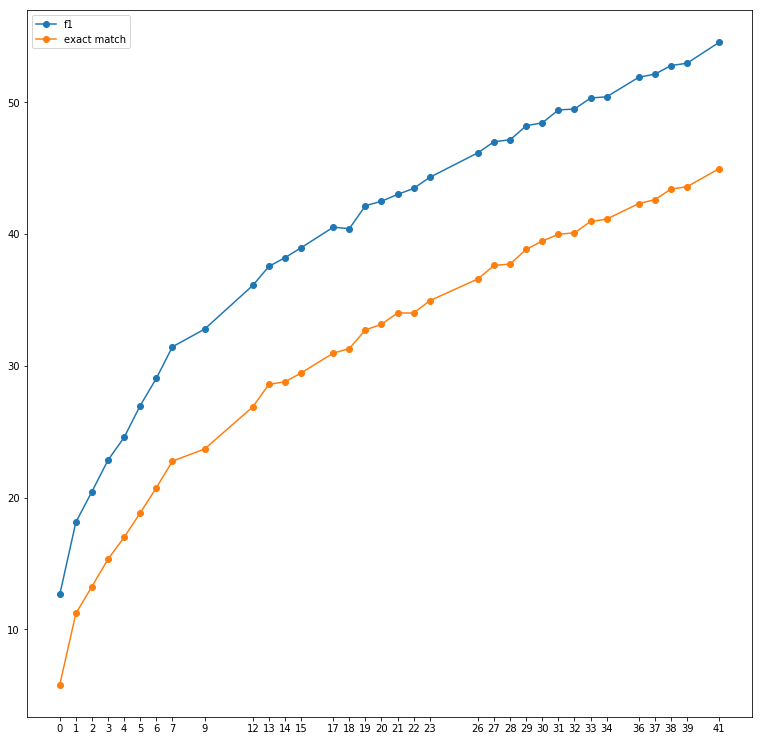

In [61]:
s1 = np.array(f1)
s2 = np.array(exact)
plt.figure(figsize=(13,13))
plt.plot(t, s1, marker='o', label='f1')
plt.plot(t, s2, marker='o', label='exact match')
plt.legend(loc='upper left')

plt.xticks(t)

plt.show()





In [3]:
logs = '435/435 [==============================] - 2368s - loss: 8.2029 - answer_start_loss: 4.2008 - answer_end_loss: 4.0021 - answer_start_acc: 0.0726 - answer_end_acc: 0.0810 - val_loss: 7.9679 - val_answer_start_loss: 4.0343 - val_answer_end_loss: 3.9336 - val_answer_start_acc: 0.$179 - val_answer_end_acc: 0.1099\n\
435/435 [==============================] - 2351s - loss: 6.9527 - answer_start_loss: 3.5942 - answer_end_loss: 3.3585 - answer_start_acc: 0.1457 - answer_end_acc: 0.1598 - val_loss: 7.0420 - val_answer_start_loss: 3.6657 - val_answer_end_loss: 3.3763 - val_answer_start_acc: 0.$645 - val_answer_end_acc: 0.1713\n\
435/435 [==============================] - 2347s - loss: 6.4992 - answer_start_loss: 3.3642 - answer_end_loss: 3.1350 - answer_start_acc: 0.1824 - answer_end_acc: 0.1974 - val_loss: 6.8159 - val_answer_start_loss: 3.5408 - val_answer_end_loss: 3.2751 - val_answer_start_acc: 0.$892 - val_answer_end_acc: 0.2029\n\
435/435 [==============================] - 2346s - loss: 6.2776 - answer_start_loss: 3.2515 - answer_end_loss: 3.0261 - answer_start_acc: 0.2017 - answer_end_acc: 0.2179 - val_loss: 6.3305 - val_answer_start_loss: 3.2743 - val_answer_end_loss: 3.0563 - val_answer_start_acc: 0.$185 - val_answer_end_acc: 0.2296\n\
435/435 [==============================] - 2347s - loss: 6.0998 - answer_start_loss: 3.1618 - answer_end_loss: 2.9380 - answer_start_acc: 0.2184 - answer_end_acc: 0.2350 - val_loss: 6.1421 - val_answer_start_loss: 3.2040 - val_answer_end_loss: 2.9381 - val_answer_start_acc: 0.$254 - val_answer_end_acc: 0.2413\n\
435/435 [==============================] - 2350s - loss: 5.9379 - answer_start_loss: 3.0785 - answer_end_loss: 2.8594 - answer_start_acc: 0.2320 - answer_end_acc: 0.2502 - val_loss: 6.0799 - val_answer_start_loss: 3.1331 - val_answer_end_loss: 2.9468 - val_answer_start_acc: 0.2396 - val_answer_end_acc: 0.2554\n\
435/435 [==============================] - 2354s - loss: 5.7901 - answer_start_loss: 3.0024 - answer_end_loss: 2.7877 - answer_start_acc: 0.2480 - answer_end_acc: 0.2658 - val_loss: 5.8412 - val_answer_start_loss: 3.0186 - val_answer_end_loss: 2.8226 - val_answer_start_acc: 0.2574 - val_answer_end_acc: 0.2713\n\
435/435 [==============================] - 2355s - loss: 5.6619 - answer_start_loss: 2.9358 - answer_end_loss: 2.7261 - answer_start_acc: 0.2593 - answer_end_acc: 0.2789 - val_loss: 5.6861 - val_answer_start_loss: 2.9359 - val_answer_end_loss: 2.7503 - val_answer_start_acc: 0.2727 - val_answer_end_acc: 0.2872\n\
435/435 [==============================] - 2353s - loss: 5.5524 - answer_start_loss: 2.8785 - answer_end_loss: 2.6740 - answer_start_acc: 0.2691 - answer_end_acc: 0.2886 - val_loss: 5.7234 - val_answer_start_loss: 2.9294 - val_answer_end_loss: 2.7940 - val_answer_start_acc: 0.2805 - val_answer_end_acc: 0.2984\n\
435/435 [==============================] - 2354s - loss: 5.4670 - answer_start_loss: 2.8339 - answer_end_loss: 2.6330 - answer_start_acc: 0.2796 - answer_end_acc: 0.2984 - val_loss: 5.6007 - val_answer_start_loss: 2.8791 - val_answer_end_loss: 2.7216 - val_answer_start_acc: 0.2818 - val_answer_end_acc: 0.2983\n\
435/435 [==============================] - 2346s - loss: 5.3704 - answer_start_loss: 2.7863 - answer_end_loss: 2.5841 - answer_start_acc: 0.2878 - answer_end_acc: 0.3103 - val_loss: 5.6832 - val_answer_start_loss: 2.8930 - val_answer_end_loss: 2.7903 - val_answer_start_acc: 0.2854 - val_answer_end_acc: 0.3002\n\
435/435 [==============================] - 2353s - loss: 5.2969 - answer_start_loss: 2.7474 - answer_end_loss: 2.5495 - answer_start_acc: 0.2972 - answer_end_acc: 0.3155 - val_loss: 5.6941 - val_answer_start_loss: 2.8757 - val_answer_end_loss: 2.8184 - val_answer_start_acc: 0.3058 - val_answer_end_acc: 0.3183\n\
435/435 [==============================] - 2351s - loss: 5.2213 - answer_start_loss: 2.7104 - answer_end_loss: 2.5109 - answer_start_acc: 0.3062 - answer_end_acc: 0.3263 - val_loss: 5.4389 - val_answer_start_loss: 2.7893 - val_answer_end_loss: 2.6496 - val_answer_start_acc: 0.3061 - val_answer_end_acc: 0.3344\n\
435/435 [==============================] - 2352s - loss: 5.1517 - answer_start_loss: 2.6747 - answer_end_loss: 2.4770 - answer_start_acc: 0.3102 - answer_end_acc: 0.3315 - val_loss: 5.2312 - val_answer_start_loss: 2.6996 - val_answer_end_loss: 2.5316 - val_answer_start_acc: 0.3147 - val_answer_end_acc: 0.3440\n\
435/435 [==============================] - 2355s - loss: 5.0964 - answer_start_loss: 2.6459 - answer_end_loss: 2.4505 - answer_start_acc: 0.3154 - answer_end_acc: 0.3376 - val_loss: 5.1752 - val_answer_start_loss: 2.6697 - val_answer_end_loss: 2.5056 - val_answer_start_acc: 0.3297 - val_answer_end_acc: 0.3525\n\
435/435 [==============================] - 2349s - loss: 5.0310 - answer_start_loss: 2.6121 - answer_end_loss: 2.4189 - answer_start_acc: 0.3236 - answer_end_acc: 0.3444 - val_loss: 5.0708 - val_answer_start_loss: 2.6325 - val_answer_end_loss: 2.4382 - val_answer_start_acc: 0.3325 - val_answer_end_acc: 0.3532\n\
435/435 [==============================] - 2352s - loss: 4.9616 - answer_start_loss: 2.5765 - answer_end_loss: 2.3851 - answer_start_acc: 0.3325 - answer_end_acc: 0.3519 - val_loss: 5.2059 - val_answer_start_loss: 2.6991 - val_answer_end_loss: 2.5068 - val_answer_start_acc: 0.3203 - val_answer_end_acc: 0.3481\n\
435/435 [==============================] - 2352s - loss: 4.9183 - answer_start_loss: 2.5545 - answer_end_loss: 2.3639 - answer_start_acc: 0.3365 - answer_end_acc: 0.3578 - val_loss: 5.0626 - val_answer_start_loss: 2.6359 - val_answer_end_loss: 2.4267 - val_answer_start_acc: 0.3300 - val_answer_end_acc: 0.3596\n\
435/435 [==============================] - 2597s - loss: 4.8507 - answer_start_loss: 2.5215 - answer_end_loss: 2.3292 - answer_start_acc: 0.3437 - answer_end_acc: 0.3669 - val_loss: 5.0292 - val_answer_start_loss: 2.6065 - val_answer_end_loss: 2.4226 - val_answer_start_acc: 0.$473 - val_answer_end_acc: 0.3742\n\
435/435 [==============================] - 2570s - loss: 4.8037 - answer_start_loss: 2.4962 - answer_end_loss: 2.3076 - answer_start_acc: 0.3494 - answer_end_acc: 0.3736 - val_loss: 4.9286 - val_answer_start_loss: 2.5538 - val_answer_end_loss: 2.3749 - val_answer_start_acc: 0.$459 - val_answer_end_acc: 0.3842\n\
435/435 [==============================] - 2349s - loss: 4.7492 - answer_start_loss: 2.4691 - answer_end_loss: 2.2801 - answer_start_acc: 0.3544 - answer_end_acc: 0.3800 - val_loss: 4.8338 - val_answer_start_loss: 2.5068 - val_answer_end_loss: 2.3269 - val_answer_start_acc: 0.$514 - val_answer_end_acc: 0.3820\n\
435/435 [==============================] - 2410s - loss: 4.6860 - answer_start_loss: 2.4348 - answer_end_loss: 2.2512 - answer_start_acc: 0.3600 - answer_end_acc: 0.3840 - val_loss: 4.8333 - val_answer_start_loss: 2.5075 - val_answer_end_loss: 2.3259 - val_answer_start_acc: 0.$581 - val_answer_end_acc: 0.3868\n\
435/435 [==============================] - 2683s - loss: 4.6352 - answer_start_loss: 2.4094 - answer_end_loss: 2.2258 - answer_start_acc: 0.3662 - answer_end_acc: 0.3910 - val_loss: 4.7525 - val_answer_start_loss: 2.4786 - val_answer_end_loss: 2.2739 - val_answer_start_acc: 0.3638 - val_answer_end_acc: 0.3894\n\
435/435 [==============================] - 2789s - loss: 4.5782 - answer_start_loss: 2.3803 - answer_end_loss: 2.1979 - answer_start_acc: 0.3735 - answer_end_acc: 0.3965 - val_loss: 4.6294 - val_answer_start_loss: 2.3977 - val_answer_end_loss: 2.2317 - val_answer_start_acc: 0.3688 - val_answer_end_acc: 0.3946\n\
435/435 [==============================] - 2350s - loss: 4.5184 - answer_start_loss: 2.3502 - answer_end_loss: 2.1682 - answer_start_acc: 0.3795 - answer_end_acc: 0.4021 - val_loss: 4.6492 - val_answer_start_loss: 2.4148 - val_answer_end_loss: 2.2344 - val_answer_start_acc: 0.3739 - val_answer_end_acc: 0.4055\n\
435/435 [==============================] - 2349s - loss: 4.4617 - answer_start_loss: 2.3247 - answer_end_loss: 2.1370 - answer_start_acc: 0.3844 - answer_end_acc: 0.4098 - val_loss: 4.6584 - val_answer_start_loss: 2.4068 - val_answer_end_loss: 2.2515 - val_answer_start_acc: 0.3789 - val_answer_end_acc: 0.3999\n\
435/435 [==============================] - 2351s - loss: 4.4041 - answer_start_loss: 2.2959 - answer_end_loss: 2.1082 - answer_start_acc: 0.3903 - answer_end_acc: 0.4175 - val_loss: 4.5753 - val_answer_start_loss: 2.3748 - val_answer_end_loss: 2.2005 - val_answer_start_acc: 0.3799 - val_answer_end_acc: 0.4078\n\
435/435 [==============================] - 2351s - loss: 4.3512 - answer_start_loss: 2.2666 - answer_end_loss: 2.0847 - answer_start_acc: 0.3965 - answer_end_acc: 0.4208 - val_loss: 4.4471 - val_answer_start_loss: 2.3412 - val_answer_end_loss: 2.1059 - val_answer_start_acc: 0.3823 - val_answer_end_acc: 0.4211\n\
435/435 [==============================] - 2352s - loss: 4.2943 - answer_start_loss: 2.2389 - answer_end_loss: 2.0554 - answer_start_acc: 0.4007 - answer_end_acc: 0.4281 - val_loss: 4.3448 - val_answer_start_loss: 2.2758 - val_answer_end_loss: 2.0690 - val_answer_start_acc: 0.3892 - val_answer_end_acc: 0.4261\n\
435/435 [==============================] - 2348s - loss: 4.2502 - answer_start_loss: 2.2164 - answer_end_loss: 2.0338 - answer_start_acc: 0.4081 - answer_end_acc: 0.4361 - val_loss: 4.3156 - val_answer_start_loss: 2.2636 - val_answer_end_loss: 2.0520 - val_answer_start_acc: 0.3926 - val_answer_end_acc: 0.4255\n\
435/435 [==============================] - 2353s - loss: 4.2204 - answer_start_loss: 2.1993 - answer_end_loss: 2.0211 - answer_start_acc: 0.4083 - answer_end_acc: 0.4360 - val_loss: 4.2929 - val_answer_start_loss: 2.2606 - val_answer_end_loss: 2.0323 - val_answer_start_acc: 0.3955 - val_answer_end_acc: 0.4300\n\
435/435 [==============================] - 2748s - loss: 4.1695 - answer_start_loss: 2.1723 - answer_end_loss: 1.9971 - answer_start_acc: 0.4189 - answer_end_acc: 0.4445 - val_loss: 4.2798 - val_answer_start_loss: 2.2442 - val_answer_end_loss: 2.0355 - val_answer_start_acc: 0.3969 - val_answer_end_acc: 0.4297\n\
435/435 [==============================] - 2352s - loss: 4.1390 - answer_start_loss: 2.1563 - answer_end_loss: 1.9827 - answer_start_acc: 0.4198 - answer_end_acc: 0.4451 - val_loss: 4.2738 - val_answer_start_loss: 2.2390 - val_answer_end_loss: 2.0348 - val_answer_start_acc: 0.4032 - val_answer_end_acc: 0.4412\n\
435/435 [==============================] - 2357s - loss: 4.0944 - answer_start_loss: 2.1333 - answer_end_loss: 1.9611 - answer_start_acc: 0.4248 - answer_end_acc: 0.4512 - val_loss: 4.2328 - val_answer_start_loss: 2.2226 - val_answer_end_loss: 2.0101 - val_answer_start_acc: 0.4054 - val_answer_end_acc: 0.4379\n\
435/435 [==============================] - 2350s - loss: 4.0543 - answer_start_loss: 2.1127 - answer_end_loss: 1.9416 - answer_start_acc: 0.4295 - answer_end_acc: 0.4555 - val_loss: 4.1135 - val_answer_start_loss: 2.1621 - val_answer_end_loss: 1.9514 - val_answer_start_acc: 0.4170 - val_answer_end_acc: 0.4511\n\
435/435 [==============================] - 2349s - loss: 4.0195 - answer_start_loss: 2.0967 - answer_end_loss: 1.9228 - answer_start_acc: 0.4342 - answer_end_acc: 0.4616 - val_loss: 4.2172 - val_answer_start_loss: 2.2159 - val_answer_end_loss: 2.0013 - val_answer_start_acc: 0.4070 - val_answer_end_acc: 0.4485\n\
435/435 [==============================] - 2349s - loss: 3.9688 - answer_start_loss: 2.0688 - answer_end_loss: 1.9000 - answer_start_acc: 0.4394 - answer_end_acc: 0.4659 - val_loss: 4.1121 - val_answer_start_loss: 2.1596 - val_answer_end_loss: 1.9525 - val_answer_start_acc: 0.4186 - val_answer_end_acc: 0.4593\n\
435/435 [==============================] - 2350s - loss: 3.9368 - answer_start_loss: 2.0529 - answer_end_loss: 1.8839 - answer_start_acc: 0.4442 - answer_end_acc: 0.4710 - val_loss: 4.1071 - val_answer_start_loss: 2.1514 - val_answer_end_loss: 1.9557 - val_answer_start_acc: 0.4212 - val_answer_end_acc: 0.4585\n\
435/435 [==============================] - 2351s - loss: 3.8999 - answer_start_loss: 2.0319 - answer_end_loss: 1.8680 - answer_start_acc: 0.4493 - answer_end_acc: 0.4759 - val_loss: 4.0820 - val_answer_start_loss: 2.1542 - val_answer_end_loss: 1.9277 - val_answer_start_acc: 0.4254 - val_answer_end_acc: 0.4680\n\
435/435 [==============================] - 2352s - loss: 3.8659 - answer_start_loss: 2.0172 - answer_end_loss: 1.8487 - answer_start_acc: 0.4546 - answer_end_acc: 0.4829 - val_loss: 4.0163 - val_answer_start_loss: 2.1075 - val_answer_end_loss: 1.9087 - val_answer_start_acc: 0.4304 - val_answer_end_acc: 0.4649\n\
435/435 [==============================] - 2350s - loss: 3.8291 - answer_start_loss: 1.9973 - answer_end_loss: 1.8318 - answer_start_acc: 0.4567 - answer_end_acc: 0.4848 - val_loss: 4.0531 - val_answer_start_loss: 2.1354 - val_answer_end_loss: 1.9177 - val_answer_start_acc: 0.4284 - val_answer_end_acc: 0.4724\n\
435/435 [==============================] - 2352s - loss: 3.7894 - answer_start_loss: 1.9763 - answer_end_loss: 1.8130 - answer_start_acc: 0.4610 - answer_end_acc: 0.4898 - val_loss: 4.0079 - val_answer_start_loss: 2.1063 - val_answer_end_loss: 1.9017 - val_answer_start_acc: 0.4340 - val_answer_end_acc: 0.4732'

In [7]:
for line in logs.split('\n'):
    print(line)
    print('-0----------')

435/435 [==============================] - 2368s - loss: 8.2029 - answer_start_loss: 4.2008 - answer_end_loss: 4.0021 - answer_start_acc: 0.0726 - answer_end_acc: 0.0810 - val_loss: 7.9679 - val_answer_start_loss: 4.0343 - val_answer_end_loss: 3.9336 - val_answer_start_acc: 0.$179 - val_answer_end_acc: 0.1099
-0----------
435/435 [==============================] - 2351s - loss: 6.9527 - answer_start_loss: 3.5942 - answer_end_loss: 3.3585 - answer_start_acc: 0.1457 - answer_end_acc: 0.1598 - val_loss: 7.0420 - val_answer_start_loss: 3.6657 - val_answer_end_loss: 3.3763 - val_answer_start_acc: 0.$645 - val_answer_end_acc: 0.1713
-0----------
435/435 [==============================] - 2347s - loss: 6.4992 - answer_start_loss: 3.3642 - answer_end_loss: 3.1350 - answer_start_acc: 0.1824 - answer_end_acc: 0.1974 - val_loss: 6.8159 - val_answer_start_loss: 3.5408 - val_answer_end_loss: 3.2751 - val_answer_start_acc: 0.$892 - val_answer_end_acc: 0.2029
-0----------
435/435 [===================

In [19]:
import re 
loss_arr = []
loss_start_arr = []
loss_end_arr = []
for line in logs.split('\n'):
    m = re.search('loss: [0-9]+(\.[0-9]{1,5})?', line)
    n = re.search('answer_start_loss: [0-9]+(\.[0-9]{1,5})?', line)
    o = re.search('answer_end_loss: [0-9]+(\.[0-9]{1,5})?', line)
    loss_arr.append((float)(m.group(0).split(':')[1]))
    loss_start_arr.append((float)(n.group(0).split(':')[1]))
    loss_end_arr.append((float)(o.group(0).split(':')[1]))

In [30]:
 t = []
for i in range(len(loss_arr)):
    t.append(i)

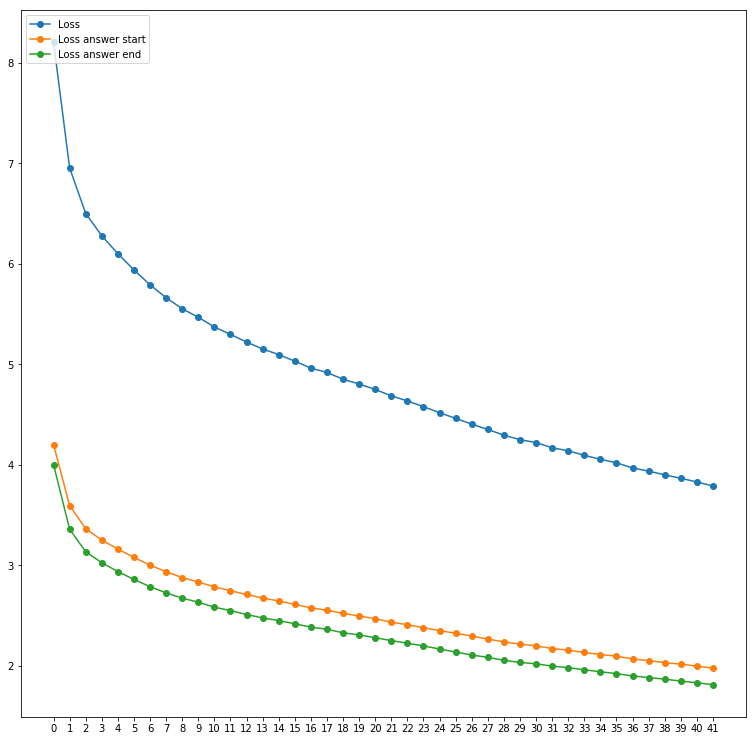

In [33]:
s1 = np.array(loss_arr)
s2 = np.array(loss_start_arr)
s3 = np.array(loss_end_arr)
plt.figure(figsize=(13,13))
plt.plot(t, s1, marker='o', label='Loss')
plt.plot(t, s2, marker='o', label='Loss answer start')
plt.plot(t, s3, marker='o', label='Loss answer end')
plt.legend(loc='upper left')

plt.xticks(t)

plt.show()

In [47]:
logs_fqa = '10000/10000 [==============================] - 162s 16ms/step - loss: 14.4568 - dense_1_loss: 7.1960 - dense_2_loss: 7.2608 - dense_1_acc: 0.0230 - dense_2_acc: 0.0019\n\
10000/10000 [==============================] - 160s 16ms/step - loss: 13.3812 - dense_1_loss: 6.6479 - dense_2_loss: 6.7333 - dense_1_acc: 0.0244 - dense_2_acc: 0.0061\n\
10000/10000 [==============================] - 160s 16ms/step - loss: 13.2717 - dense_1_loss: 6.5903 - dense_2_loss: 6.6814 - dense_1_acc: 0.0292 - dense_2_acc: 0.0064\n\
10000/10000 [==============================] - 160s 16ms/step - loss: 13.1375 - dense_1_loss: 6.5162 - dense_2_loss: 6.6213 - dense_1_acc: 0.0349 - dense_2_acc: 0.0067\n\
10000/10000 [==============================] - 160s 16ms/step - loss: 12.9636 - dense_1_loss: 6.4292 - dense_2_loss: 6.5344 - dense_1_acc: 0.0366 - dense_2_acc: 0.0088\n\
10000/10000 [==============================] - 160s 16ms/step - loss: 12.7677 - dense_1_loss: 6.3324 - dense_2_loss: 6.4353 - dense_1_acc: 0.0368 - dense_2_acc: 0.0107\n\
10000/10000 [==============================] - 160s 16ms/step - loss: 12.5584 - dense_1_loss: 6.2301 - dense_2_loss: 6.3283 - dense_1_acc: 0.0366 - dense_2_acc: 0.0126\n\
10000/10000 [==============================] - 160s 16ms/step - loss: 12.3377 - dense_1_loss: 6.1209 - dense_2_loss: 6.2168 - dense_1_acc: 0.0402 - dense_2_acc: 0.0180\n\
10000/10000 [==============================] - 160s 16ms/step - loss: 12.1039 - dense_1_loss: 6.0031 - dense_2_loss: 6.1008 - dense_1_acc: 0.0436 - dense_2_acc: 0.0221\n\
10000/10000 [==============================] - 160s 16ms/step - loss: 11.8728 - dense_1_loss: 5.8928 - dense_2_loss: 5.9800 - dense_1_acc: 0.0466 - dense_2_acc: 0.0269\n\
10000/10000 [==============================] - 160s 16ms/step - loss: 11.6422 - dense_1_loss: 5.7756 - dense_2_loss: 5.8666 - dense_1_acc: 0.0493 - dense_2_acc: 0.0319\n\
10000/10000 [==============================] - 160s 16ms/step - loss: 11.4145 - dense_1_loss: 5.6668 - dense_2_loss: 5.7477 - dense_1_acc: 0.0538 - dense_2_acc: 0.0392\n\
10000/10000 [==============================] - 160s 16ms/step - loss: 11.1825 - dense_1_loss: 5.5515 - dense_2_loss: 5.6309 - dense_1_acc: 0.0597 - dense_2_acc: 0.0458\n\
10000/10000 [==============================] - 160s 16ms/step - loss: 10.9768 - dense_1_loss: 5.4519 - dense_2_loss: 5.5249 - dense_1_acc: 0.0653 - dense_2_acc: 0.0518\n\
10000/10000 [==============================] - 160s 16ms/step - loss: 10.7682 - dense_1_loss: 5.3487 - dense_2_loss: 5.4195 - dense_1_acc: 0.0717 - dense_2_acc: 0.0585\n\
10000/10000 [==============================] - 160s 16ms/step - loss: 10.5612 - dense_1_loss: 5.2459 - dense_2_loss: 5.3152 - dense_1_acc: 0.0753 - dense_2_acc: 0.0678\n\
10000/10000 [==============================] - 160s 16ms/step - loss: 10.3524 - dense_1_loss: 5.1445 - dense_2_loss: 5.2079 - dense_1_acc: 0.0802 - dense_2_acc: 0.0762\n\
10000/10000 [==============================] - 160s 16ms/step - loss: 10.1634 - dense_1_loss: 5.0559 - dense_2_loss: 5.1074 - dense_1_acc: 0.0893 - dense_2_acc: 0.0812\n\
10000/10000 [==============================] - 160s 16ms/step - loss: 9.9767 - dense_1_loss: 4.9597 - dense_2_loss: 5.0171 - dense_1_acc: 0.0945 - dense_2_acc: 0.0867\n\
10000/10000 [==============================] - 160s 16ms/step - loss: 9.8060 - dense_1_loss: 4.8791 - dense_2_loss: 4.9269 - dense_1_acc: 0.0994 - dense_2_acc: 0.0946\n\
10000/10000 [==============================] - 160s 16ms/step - loss: 9.6381 - dense_1_loss: 4.7965 - dense_2_loss: 4.8416 - dense_1_acc: 0.1068 - dense_2_acc: 0.1020\n\
10000/10000 [==============================] - 160s 16ms/step - loss: 9.4637 - dense_1_loss: 4.7105 - dense_2_loss: 4.7532 - dense_1_acc: 0.1150 - dense_2_acc: 0.1093\n\
10000/10000 [==============================] - 160s 16ms/step - loss: 9.3218 - dense_1_loss: 4.6406 - dense_2_loss: 4.6812 - dense_1_acc: 0.1176 - dense_2_acc: 0.1132\n\
10000/10000 [==============================] - 160s 16ms/step - loss: 9.1596 - dense_1_loss: 4.5584 - dense_2_loss: 4.6011 - dense_1_acc: 0.1246 - dense_2_acc: 0.1156\n\
10000/10000 [==============================] - 160s 16ms/step - loss: 9.0047 - dense_1_loss: 4.4805 - dense_2_loss: 4.5241 - dense_1_acc: 0.1298 - dense_2_acc: 0.1247\n\
10000/10000 [==============================] - 160s 16ms/step - loss: 8.8672 - dense_1_loss: 4.4155 - dense_2_loss: 4.4517 - dense_1_acc: 0.1334 - dense_2_acc: 0.1285\n\
10000/10000 [==============================] - 160s 16ms/step - loss: 8.7344 - dense_1_loss: 4.3494 - dense_2_loss: 4.3850 - dense_1_acc: 0.1366 - dense_2_acc: 0.1309\n\
10000/10000 [==============================] - 160s 16ms/step - loss: 8.6049 - dense_1_loss: 4.2834 - dense_2_loss: 4.3215 - dense_1_acc: 0.1419 - dense_2_acc: 0.1385\n\
10000/10000 [==============================] - 160s 16ms/step - loss: 8.4648 - dense_1_loss: 4.2184 - dense_2_loss: 4.2463 - dense_1_acc: 0.1438 - dense_2_acc: 0.1469\n\
10000/10000 [==============================] - 160s 16ms/step - loss: 8.3550 - dense_1_loss: 4.1638 - dense_2_loss: 4.1912 - dense_1_acc: 0.1496 - dense_2_acc: 0.1482\n\
20000/20000 [==============================] - 294s 15ms/step - loss: 10.6324 - dense_1_loss: 5.2697 - dense_2_loss: 5.3627 - dense_1_acc: 0.0820 - dense_2_acc: 0.0659\n\
20000/20000 [==============================] - 293s 15ms/step - loss: 10.0700 - dense_1_loss: 4.9905 - dense_2_loss: 5.0795 - dense_1_acc: 0.0943 - dense_2_acc: 0.0791\n\
20000/20000 [==============================] - 293s 15ms/step - loss: 9.7762 - dense_1_loss: 4.8467 - dense_2_loss: 4.9295 - dense_1_acc: 0.1042 - dense_2_acc: 0.0916\n\
20000/20000 [==============================] - 293s 15ms/step - loss: 9.5593 - dense_1_loss: 4.7428 - dense_2_loss: 4.8165 - dense_1_acc: 0.1086 - dense_2_acc: 0.1001\n\
20000/20000 [==============================] - 293s 15ms/step - loss: 9.3806 - dense_1_loss: 4.6554 - dense_2_loss: 4.7252 - dense_1_acc: 0.1166 - dense_2_acc: 0.1064\n\
20000/20000 [==============================] - 293s 15ms/step - loss: 9.2246 - dense_1_loss: 4.5734 - dense_2_loss: 4.6512 - dense_1_acc: 0.1209 - dense_2_acc: 0.1119\n\
20000/20000 [==============================] - 293s 15ms/step - loss: 9.0994 - dense_1_loss: 4.5148 - dense_2_loss: 4.5847 - dense_1_acc: 0.1238 - dense_2_acc: 0.1155\n\
20000/20000 [==============================] - 293s 15ms/step - loss: 8.9918 - dense_1_loss: 4.4633 - dense_2_loss: 4.5285 - dense_1_acc: 0.1285 - dense_2_acc: 0.1221\n\
20000/20000 [==============================] - 293s 15ms/step - loss: 8.8638 - dense_1_loss: 4.3986 - dense_2_loss: 4.4652 - dense_1_acc: 0.1331 - dense_2_acc: 0.1258\n\
20000/20000 [==============================] - 293s 15ms/step - loss: 8.7579 - dense_1_loss: 4.3464 - dense_2_loss: 4.4115 - dense_1_acc: 0.1386 - dense_2_acc: 0.1310\n\
20000/20000 [==============================] - 293s 15ms/step - loss: 8.6639 - dense_1_loss: 4.2998 - dense_2_loss: 4.3642 - dense_1_acc: 0.1394 - dense_2_acc: 0.1310\n\
20000/20000 [==============================] - 293s 15ms/step - loss: 8.4819 - dense_1_loss: 4.2093 - dense_2_loss: 4.2727 - dense_1_acc: 0.1463 - dense_2_acc: 0.1404\n\
20000/20000 [==============================] - 293s 15ms/step - loss: 8.3286 - dense_1_loss: 4.1322 - dense_2_loss: 4.1964 - dense_1_acc: 0.1504 - dense_2_acc: 0.1441\n\
20000/20000 [==============================] - 293s 15ms/step - loss: 8.2501 - dense_1_loss: 4.0910 - dense_2_loss: 4.1591 - dense_1_acc: 0.1522 - dense_2_acc: 0.1458\n\
20000/20000 [==============================] - 293s 15ms/step - loss: 8.2501 - dense_1_loss: 4.0910 - dense_2_loss: 4.1591 - dense_1_acc: 0.1522 - dense_2_acc: 0.1458\n\
20000/20000 [==============================] - 293s 15ms/step - loss: 8.1766 - dense_1_loss: 4.0556 - dense_2_loss: 4.1209 - dense_1_acc: 0.1585 - dense_2_acc: 0.1535\n\
20000/20000 [==============================] - 293s 15ms/step - loss: 8.0985 - dense_1_loss: 4.0191 - dense_2_loss: 4.0794 - dense_1_acc: 0.1577 - dense_2_acc: 0.1517\n\
20000/20000 [==============================] - 293s 15ms/step - loss: 8.0188 - dense_1_loss: 3.9864 - dense_2_loss: 4.0324 - dense_1_acc: 0.1606 - dense_2_acc: 0.1555\n\
20000/20000 [==============================] - 292s 15ms/step - loss: 7.9605 - dense_1_loss: 3.9500 - dense_2_loss: 4.0105 - dense_1_acc: 0.1645 - dense_2_acc: 0.1557\n\
20000/20000 [==============================] - 293s 15ms/step - loss: 7.8844 - dense_1_loss: 3.9179 - dense_2_loss: 3.9665 - dense_1_acc: 0.1656 - dense_2_acc: 0.1620\n\
20000/20000 [==============================] - 293s 15ms/step - loss: 7.9865 - dense_1_loss: 3.9652 - dense_2_loss: 4.0213 - dense_1_acc: 0.1602 - dense_2_acc: 0.1565\n\
20000/20000 [==============================] - 293s 15ms/step - loss: 7.8832 - dense_1_loss: 3.9111 - dense_2_loss: 3.9721 - dense_1_acc: 0.1597 - dense_2_acc: 0.1613\n\
20000/20000 [==============================] - 293s 15ms/step - loss: 7.7919 - dense_1_loss: 3.8687 - dense_2_loss: 3.9232 - dense_1_acc: 0.1641 - dense_2_acc: 0.1618\n\
20000/20000 [==============================] - 293s 15ms/step - loss: 7.8310 - dense_1_loss: 3.8847 - dense_2_loss: 3.9463 - dense_1_acc: 0.1650 - dense_2_acc: 0.1603\n\
20000/20000 [==============================] - 293s 15ms/step - loss: 7.7073 - dense_1_loss: 3.8265 - dense_2_loss: 3.8808 - dense_1_acc: 0.1699 - dense_2_acc: 0.1643\n\
20000/20000 [==============================] - 293s 15ms/step - loss: 7.6365 - dense_1_loss: 3.7931 - dense_2_loss: 3.8434 - dense_1_acc: 0.1732 - dense_2_acc: 0.1678\n\
20000/20000 [==============================] - 293s 15ms/step - loss: 7.5472 - dense_1_loss: 3.7498 - dense_2_loss: 3.7975 - dense_1_acc: 0.1753 - dense_2_acc: 0.1760\n\
20000/20000 [==============================] - 293s 15ms/step - loss: 7.4756 - dense_1_loss: 3.7151 - dense_2_loss: 3.7605 - dense_1_acc: 0.1783 - dense_2_acc: 0.1747\n\
20000/20000 [==============================] - 293s 15ms/step - loss: 7.4310 - dense_1_loss: 3.6898 - dense_2_loss: 3.7412 - dense_1_acc: 0.1772 - dense_2_acc: 0.1778'

In [48]:
loss_arr = []
loss_start_arr = []
loss_end_arr = []
for line in logs_fqa.split('\n'):
    m = re.search(' loss: ([0-9]{1,2})+(\.[0-9]{1,5})?', line)
    n = re.search('dense_1_loss: ([0-9]{1,2})+(\.[0-9]{1,5})?', line)
    o = re.search('dense_2_loss: ([0-9]{1,2})+(\.[0-9]{1,5})?', line)
    loss_arr.append((float)(m.group(0).split(':')[1]))
    loss_start_arr.append((float)(n.group(0).split(':')[1]))
    loss_end_arr.append((float)(o.group(0).split(':')[1]))

In [49]:
 t = []
for i in range(len(loss_arr)):
    t.append(i)

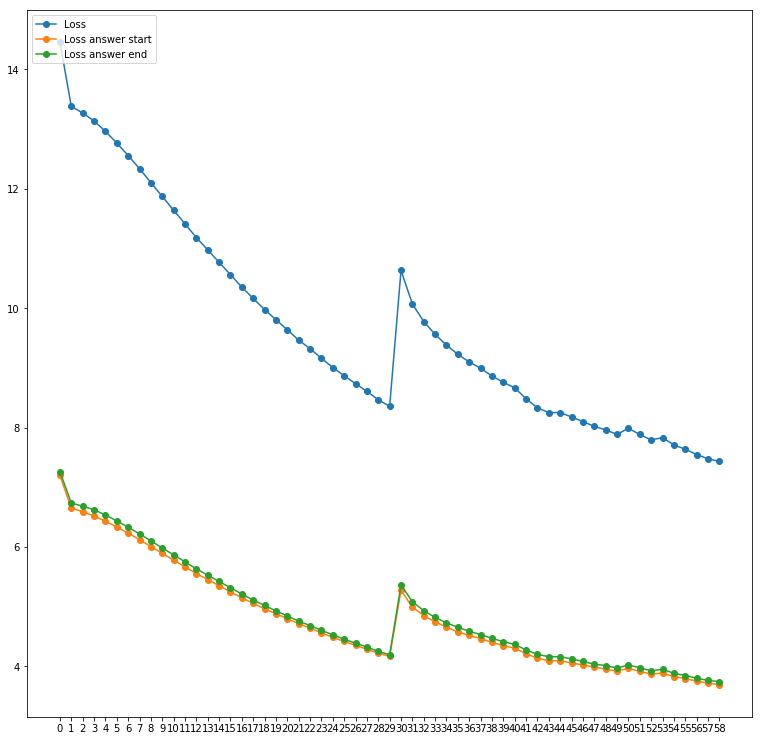

In [50]:
s1 = np.array(loss_arr)
s2 = np.array(loss_start_arr)
s3 = np.array(loss_end_arr)
plt.figure(figsize=(13,13))
plt.plot(t, s1, marker='o', label='Loss')
plt.plot(t, s2, marker='o', label='Loss answer start')
plt.plot(t, s3, marker='o', label='Loss answer end')
plt.legend(loc='upper left')

plt.xticks(t)

plt.show()